# Mr.PolicyHelperAI Enhanced RAG System Using LangChain

## 1. Install and Import the Required Libraries

In [1]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import os, json
import tiktoken
import openai
import chromadb
import warnings
warnings.filterwarnings("ignore")

## 2. Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [2]:
# Define the path of the PDF

pdf_path = 'Policy+Documents/HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf'

#### 2.1  Reading a single PDF file and exploring it through pdfplumber

In [3]:
# Open the PDF file
with pdfplumber.open(pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[6]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

apart; and
ii. Requiring continuous permanent supplementary oxygen therapy for hypoxemia;
and
iii. Arterial blood gas analysis with partial oxygen pressure of 55mmHg or less
(PaO2 < 55mmHg); and
iv. Dyspnea at rest.
Confirmation by a consultant physician acceptable to the Company of the loss of
independent existence due to Illness or trauma, which has lasted for a minimum
period of 6 months and results in a permanent inability to perform at least three (3) of
the Activities of Daily Living (either with or without the use of mechanical
equipment, special devices or other aids and adaptations in use for disabled persons).
For the purpose of this benefit, the word “permanent”, shall mean beyond the hope of
recovery with current medical knowledge and technology.
Activities of Daily Living are:-
a) Washing: the ability to wash in the bath or shower (including getting into and out
of the bath or shower) or wash satisfactorily by other means.
Loss of
b) Dressing: the ability to put on, take o

In [4]:
# Define the path where all pdf documents are present

pdf_path = 'Policy+Documents/'

In [5]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [6]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [7]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf
Finished processing HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf
...Processing HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf
Finished processing HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf
...Processing HDFC-Life-Group-Term-Life-Policy.pdf
Finished processing HDFC-Life-Group-Term-Life-Policy.pdf
...Processing HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf
Finished processing HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf
...Processing HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf
Finished processing HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf
...Processing HDFC-Life-Smart-Pension-Plan-Policy-Document-Online.pdf
Finished processing HDFC-Life-Smart-Pension-Plan-Policy-Document-Online.pdf
...Processing HDFC-Surgicare-Plan-101N043V01.pdf
Finished processing HDFC-Surgicare-

In [8]:
# Convert the data to a dataframe

insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [9]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name
0,Page 1,Part A <<Date>> <<Policyholder’s Name>> <<Poli...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...
1,Page 2,Agency/Intermediary Contact Details: <<Agency/...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...
2,Page 3,POLICY DOCUMENT- HDFC LIFE EASY HEALTH Unique ...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...
3,Page 4,"[[null, ""<< dd/mm/yyyy >>""], [""Appointee's Add...",HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...
4,Page 5,Part B Definitions The following capitalised t...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...
...,...,...,...
212,Page 11,HDFC Standard Life Insurance Company Limited H...,HDFC-Surgicare-Plan-101N043V01.pdf
213,Page 12,HDFC Standard Life Insurance Company Limited H...,HDFC-Surgicare-Plan-101N043V01.pdf
214,Page 13,HDFC Standard Life Insurance Company Limited H...,HDFC-Surgicare-Plan-101N043V01.pdf
215,Page 14,HDFC Standard Life Insurance Company Limited H...,HDFC-Surgicare-Plan-101N043V01.pdf


In [10]:
# Check one of the extracted page texts to ensure that the text has been correctly read

insurance_pdfs_data.Page_Text[2]

'POLICY DOCUMENT- HDFC LIFE EASY HEALTH Unique Identification Number: <<101N110V03>> Your Policy is a Single Premium paying non participating non linked fixed benefit health plan. This document is the evidence of a contract between HDFC Life Insurance Company Limited and the Policyholder as described in the Policy Schedule given below. This Policy is based on the Proposal made by the within named Policyholder and submitted to the Company along with the required documents, declarations, statements, any response given to the Short Medical Questionnaire (SMQ) by the Life Assured, and other information received by the Company from the Policyholder, Life Assured or on behalf of the Policyholder. This Policy is effective upon receipt and realisation, by the Company, of the consideration payable as Premium under the Policy. This Policy is written under and will be governed by the applicable laws in force in India and all Premiums and Benefits are expressed and payable in Indian Rupees. POLICY

In [11]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [12]:
insurance_pdfs_data['Text_Length']

0      508
1       85
2      298
3       63
4      514
      ... 
212    316
213    353
214    348
215    496
216    171
Name: Text_Length, Length: 217, dtype: int64

In [13]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,Part A <<Date>> <<Policyholder’s Name>> <<Poli...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,508
1,Page 2,Agency/Intermediary Contact Details: <<Agency/...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,85
2,Page 3,POLICY DOCUMENT- HDFC LIFE EASY HEALTH Unique ...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,298
3,Page 4,"[[null, ""<< dd/mm/yyyy >>""], [""Appointee's Add...",HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,63
4,Page 5,Part B Definitions The following capitalised t...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,514
...,...,...,...,...
212,Page 11,HDFC Standard Life Insurance Company Limited H...,HDFC-Surgicare-Plan-101N043V01.pdf,316
213,Page 12,HDFC Standard Life Insurance Company Limited H...,HDFC-Surgicare-Plan-101N043V01.pdf,353
214,Page 13,HDFC Standard Life Insurance Company Limited H...,HDFC-Surgicare-Plan-101N043V01.pdf,348
215,Page 14,HDFC Standard Life Insurance Company Limited H...,HDFC-Surgicare-Plan-101N043V01.pdf,496


In [14]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

In [15]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,Part A <<Date>> <<Policyholder’s Name>> <<Poli...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,508,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...
1,Page 2,Agency/Intermediary Contact Details: <<Agency/...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,85,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...
2,Page 3,POLICY DOCUMENT- HDFC LIFE EASY HEALTH Unique ...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,298,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...
3,Page 4,"[[null, ""<< dd/mm/yyyy >>""], [""Appointee's Add...",HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,63,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...
4,Page 5,Part B Definitions The following capitalised t...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,514,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...
...,...,...,...,...,...
212,Page 11,HDFC Standard Life Insurance Company Limited H...,HDFC-Surgicare-Plan-101N043V01.pdf,316,{'Policy_Name': 'HDFC-Surgicare-Plan-101N043V0...
213,Page 12,HDFC Standard Life Insurance Company Limited H...,HDFC-Surgicare-Plan-101N043V01.pdf,353,{'Policy_Name': 'HDFC-Surgicare-Plan-101N043V0...
214,Page 13,HDFC Standard Life Insurance Company Limited H...,HDFC-Surgicare-Plan-101N043V01.pdf,348,{'Policy_Name': 'HDFC-Surgicare-Plan-101N043V0...
215,Page 14,HDFC Standard Life Insurance Company Limited H...,HDFC-Surgicare-Plan-101N043V01.pdf,496,{'Policy_Name': 'HDFC-Surgicare-Plan-101N043V0...


#### 2.2  Fixed-size PDF Chunking

In [16]:
# Iterating over all page titles to create the final df with individual chunks

page_nos = insurance_pdfs_data["Page No."]

In [17]:
# Function to split text into fixed-size chunks
def split_text_into_chunks(text, chunk_size):
    chunks = []
    words = text.split()  # Split the text into words

    current_chunk = []  # Store words for the current chunk
    current_chunk_word_count = 0  # Count of words in the current chunk

    for word in words:
        if current_chunk_word_count + len(word) + 1 <= chunk_size:
            current_chunk.append(word)
            current_chunk_word_count += len(word) + 1
        else:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_chunk_word_count = len(word)

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

In [18]:
def process_page(page_no):
    page = insurance_pdfs_data[insurance_pdfs_data['Page No.'] == page_no].Page_Text.values[0]
    metadata = insurance_pdfs_data[insurance_pdfs_data['Page No.'] == page_no].Metadata.values[0]

    if page is not None:
        # setting chunk size as 500
        chunk_size = 500
        text_chunks = split_text_into_chunks(page, chunk_size)

        # Creating a DataFrame to store the chunks, page title and page metadata
        data = {'Title': [], 'Chunk Text': [], 'Metadata': []}

        for index, chunk in enumerate(text_chunks):
            data['Title'].append(page_no)
            data['Chunk Text'].append(chunk)
            # adding chunk no as part of metadata
            metadata['Chunk_No.'] = index
            data['Metadata'].append(metadata)

        return pd.DataFrame(data)

In [19]:
# creating a dataframe after calling process
all_dfs = []
for page_no in page_nos:
    df = process_page(page_no)
    if df is not None:
        all_dfs.append(df)

insurance_pdfs_data = pd.concat(all_dfs, ignore_index=True)
insurance_pdfs_data

,Title,Chunk Text,Metadata
0,Page 1,Part A <<Date>> <<Policyholder’s Name>> <<Poli...,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...
1,Page 1,contract between HDFC Life Insurance Company L...,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...
2,Page 1,"stating the reasons thereof, within 30 days fr...",{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...
3,Page 1,and stamp duty charges. / In case you are not ...,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...
4,Page 1,Premium for the period of cover and the expens...,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...
...,...,...,...
1215,Page 13,accordance with provisions of Clause 9 of Part...,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...
1216,Page 13,3. Free Look Option,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...
1217,Page 14,In case you are not agreeable to any of the pr...,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...
1218,Page 14,the expenses incurred by us for medical examin...,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...


## 3. Generate and Store Embeddings using HuggingFace and FAISS

In this section, we will embed the pages in the dataframe through HuggingFace's `all-MiniLM-L6-v2` model, and store them in a FAISS Vector Store collection.

In [20]:
from langchain_huggingface import HuggingFaceEmbeddings

In [21]:
# Load the embedding model

embedding_model_name = "all-MiniLM-L6-v2"
embedder = HuggingFaceEmbeddings(model_name = embedding_model_name)

In [22]:
from langchain.vectorstores import FAISS

In [23]:
insurance_collection = FAISS.from_texts(
    embedding = embedder,
    texts = insurance_pdfs_data['Chunk Text'].to_list(),
    metadatas = insurance_pdfs_data['Metadata'].to_list()
)

## 4. Semantic Searching

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [24]:
retriever = insurance_collection.as_retriever()

In [25]:
# Read the user query

test_query = "What is the policy on eye issues?"

In [26]:
results = retriever.invoke(test_query)

for i, doc in enumerate(results):
    print(f"\nResult {i+1}:\n{doc.page_content}\nMetadata: {doc.metadata}")


Result 1:
corrected visual acuity being 3/60 or less in both eyes or ;\nii. the field of vision being less than 10 degrees in both eyes.\nThe diagnosis of blindness must be confirmed and must not be correctable by aids or\nsurgical procedure."], ["13", "Third\nDegree\nBurns", "There must be third-degree burns with scarring that cover at least 20% of the body\u2019s\nsurface area. The diagnosis must confirm the total area involved using standardized,\nclinically accepted, body surface area charts covering
Metadata: {'Policy_Name': 'HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay', 'Page_No.': 'Page 7', 'Chunk_No.': 8}

Result 2:
corrected visual acuity being 3/60 or less in both eyes or ;\nii. the field of vision being less than 10 degrees in both eyes.\nThe diagnosis of blindness must be confirmed and must not be correctable by aids or\nsurgical procedure."], ["13", "Third\nDegree\nBurns", "There must be third-degree burns with scarring that cover at least 20% of the body\u201

## 5. Re-Ranking and Compression

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a compression retriever from langchain to rerank the relevance of the response with respect to the query.
<br>
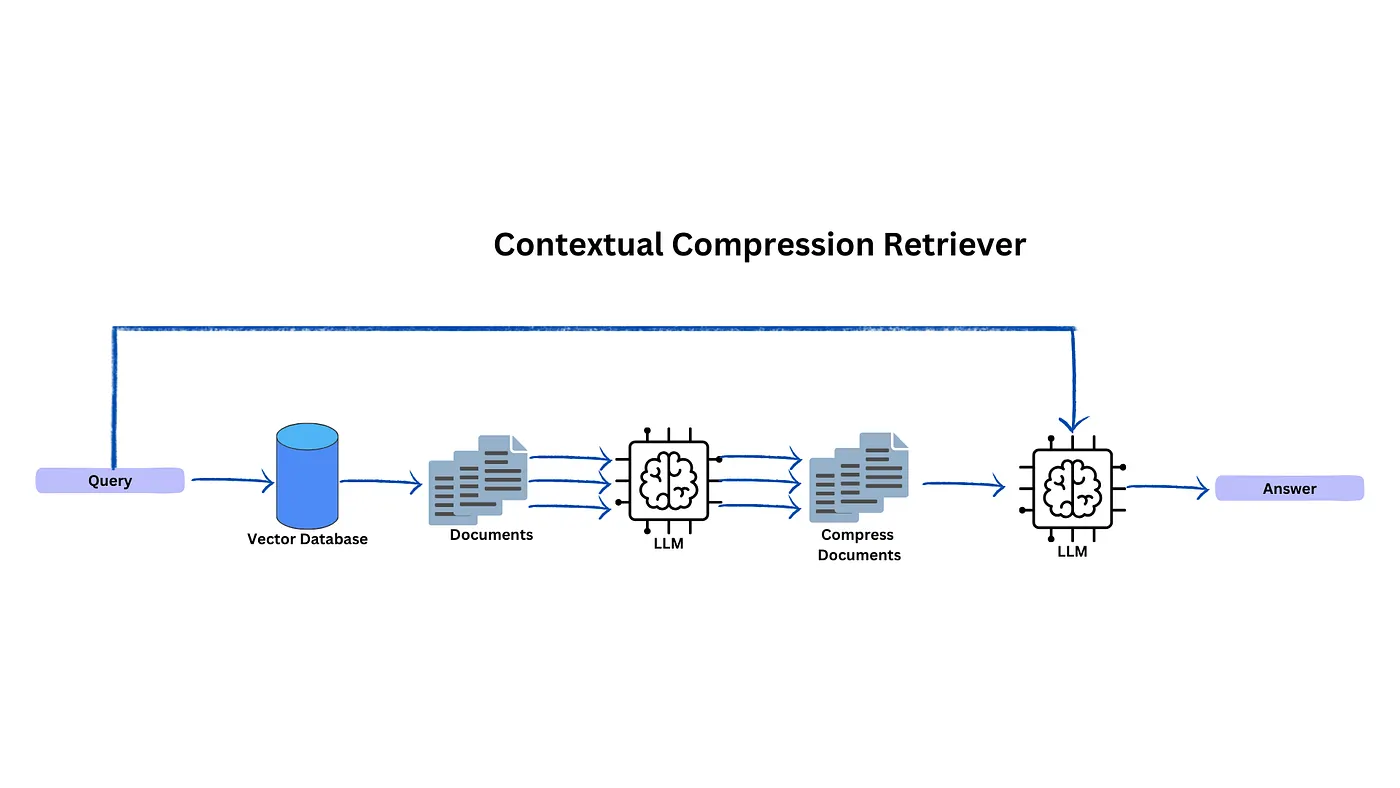
<br>

In [27]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import EmbeddingsFilter

In [28]:
compressor = EmbeddingsFilter(embeddings=embedder, similarity_threshold=0.75)

In [29]:
compressed_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=retriever
)

In [30]:
query = "Which policies cover for accidental damage and what are provided?"
reranked_results = compressed_retriever.invoke(query)

for i, doc in enumerate(reranked_results):
    print(f"\nReranked Result {i+1}:\n{doc.page_content}\nMetadata: {doc.metadata}")

## 6. Adding Langchain Memory

We will be storing the history of user interactions which helps the LLM understand context across multiple turns.

In [31]:
from langchain.memory import ConversationBufferMemory

In [32]:
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    output_key="result"  
)

C:\Users\Gourikarthik.Gembali\AppData\Local\Temp\ipykernel_19488\2507007913.py:1: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(


## 7. LLM Response Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [33]:
# Read the OpenAI API key
openai.api_key = open("OPENAI_API_Key.txt", "r").read().strip()
os.environ['OPENAI_API_KEY'] = openai.api_key

In [34]:
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

custom_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.

You have a question asked by the user: '{question}' and you have some search results from a corpus of insurance documents: '{context}'.

These search results are essentially one page of an insurance document that may be relevant to the user query.

Use the documents in the context to answer the query. Frame an informative answer and also, use the context to return the relevant policy names and page numbers as citations.

Guidelines:
1. Provide relevant/accurate numbers if available.
2. Use only relevant information.
3. If tables are present, reformat and present them clearly.
4. Refer the metadata to fetch the correct citation using policy PDF document filename(s) and page number(s).
5. Use the citation format as 
   Citation: 
   Document Name: Name of PDF Document File which contains the context related to the RAG query
   Page No: Page Number(s) in the PDF Document File which contains the context related to the RAG query
6. If the answer is incomplete, guide the user to relevant sections.
7. Do not explain internal workings—just answer directly.
8. Do not use external data source or pre-trained memory source, you shall only use the documents data memory provided here.

Return a well-formatted and easily readable response with citations.
"""
)


In [35]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.2)

In [36]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    chain_type_kwargs={"prompt": custom_prompt},
    retriever=retriever,
    memory=memory,
    return_source_documents=True,
    output_key="result"
)

## 8. Queries Validation

In [37]:
queries = [
    "How is the Daily Hospital Cash Benefit calculated and what are its limits?",
    "What happens if the full Sum Insured is exhausted under Surgical Benefit?",
    "What are the 29 critical illnesses covered under the Accelerated Critical Illness Option?",
    "What are the benefits payable under employer-employee vs. lender-borrower schemes?",
    "How is the Free Cover Limit defined and applied?",
    "What are the different Guaranteed Benefit Options available under the Sampoorna Jeevan policy?",
    "What is the difference between Sampoorna Jeevan 75 and Sampoorna Jeevan 100 variants?",
    "What are the Guaranteed Surrender Value factors for different policy terms and years?",
    "What is the vesting benefit and how can it be utilized under the HDFC Life Smart Pension Plan?",
    "What surgeries are covered under Grade A and what percentage of the sum assured is paid?"
]

for i, q in enumerate(queries):
    print("\n========================================================================================================================================================")
    print(f"\nQuery {i+1}: {q}")
    result = qa_chain.invoke({"query": q})
    print(f"Answer {i+1}:", result["result"])
print("\n========================================================================================================================================================")



Query 1: How is the Daily Hospital Cash Benefit calculated and what are its limits?
Answer 1: The Daily Hospital Cash Benefit is calculated based on the Sum Insured and is 1% of the Sum Insured for admission in non ICU rooms. The benefit amount may vary depending on the age at entry of the Policyholder. 

Citation: 
Document Name: Insurance Policy Document
Page No: Page 1


Query 2: What happens if the full Sum Insured is exhausted under Surgical Benefit?
Answer 2: Based on the information from the insurance document, if the full Sum Insured is exhausted under Surgical Benefit, the cover for Surgical Benefit will cease for the Life Assured for the remaining Policy Term. However, the Daily Hospital Cash Benefit and Critical Illness Benefit will continue to be in force.

Citation:
Document Name: Insurance Policy Document XYZ
Page No: Page 5


Query 3: What are the 29 critical illnesses covered under the Accelerated Critical Illness Option?
Answer 3: The 29 critical illnesses covered un